In [1]:
import sys
print (sys.version)

import sys
print (sys.version)

# ! pip3 install fastai==0.7.0
# ! pip3 install torchtext==0.2.3

! pip3 install torch
! pip3 install torchvision

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from fastai.conv_learner import *
# from fastai.dataset import *

import torch
import torch.nn as nn
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import torch.optim as optim
import time, copy
torch.cuda.set_device(0)

# !mkdir data
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
# !wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/
# !tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/
# !unzip data/PASCAL_VOC.zip -d data/
# !rm -rf data/PASCAL_VOC.zip data/VOCtrainval_06-Nov-2007.tar

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import collections
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
%matplotlib inline

np.random.seed(1971)

In [3]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json')]

In [4]:
train_json = json.load((PATH/'pascal_train2007.json').open())

In [5]:
train_json.keys()

dict_keys(['type', 'annotations', 'images', 'categories'])

In [6]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [7]:
images_dir = Path('./data/VOCdevkit/VOC2007/JPEGImages/')
next(images_dir.iterdir())

PosixPath('data/VOCdevkit/VOC2007/JPEGImages/003508.jpg')

In [8]:
# dictionary to keep image_id vs bbox and and corresponding category
annotation_dict = collections.defaultdict(lambda:[])
for item in train_json[ANNOTATIONS]:
#     print (item['image_id'])
#     print (item['bbox'])
#     print (item['category_id'])
    annotation_dict[item['image_id']].append((item['category_id'], item['bbox']))
#     break

In [9]:
# dictionary to keep image id to image path
image_id_to_filename = dict()
for item in train_json[IMAGES]:
    image_id_to_filename[item['id']]= images_dir/item['file_name']

In [10]:
image_id_to_category = dict()
for item in train_json[CATEGORIES]:
    image_id_to_category[item['id']]=item['name']
    
id_to_WH = dict()
for item in train_json[IMAGES]:
    id_to_WH[item['id']]={'height':item['height'], 'width':item['width']}

In [11]:
def coord_to_hw(bb):
    return np.array([bb[0], bb[1], bb[2]-bb[0]+1, bb[3]-bb[1]+1])

def hw_to_coord(bb, image_id=None, normalize=None):
    if normalize == True and image_id is not None:
        xmin = bb[0]/id_to_WH[image_id]['width']
        ymin = bb[1]/id_to_WH[image_id]['height']
        xmax = (bb[0]+bb[2])/id_to_WH[image_id]['width']
        ymax = (bb[1]+bb[3])/id_to_WH[image_id]['height']
        return np.array([xmin, ymin, xmax, ymax])
    else:
        return np.array([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])

def draw_image(image, figsize=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_bbox(ax, bbox):
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    
def add_text(ax, bb, txt):
    text = ax.text(bb[0], bb[1], txt, fontsize=14, color='white', weight='bold', backgroundcolor='black') 
    
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

from sklearn.preprocessing import LabelEncoder

class CategoryUtil:
    def __init__(self, labels):
        self.labels = np.unique(labels)
        self.encode_dict = dict()
        self.decode_dict = dict()
        for id, label in enumerate(self.labels):
            self.encode_dict[label] = id
            self.decode_dict[id] = label
            
    def encode(self, label):
        return self.encode_dict[label]
    
    def decode(self, id):
        return self.decode_dict[id]

(15, [184, 61, 95, 138])
(13, [89, 77, 314, 259])


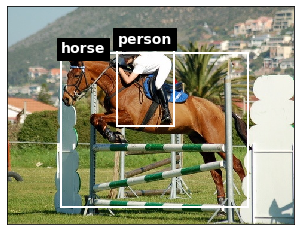

In [12]:
image_id = 17
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
for bbox in annotation_dict[image_id]:
    print (bbox)
    draw_bbox(ax, bbox[1])
    add_text(ax, bbox[1], image_id_to_category[bbox[0]])

In [13]:
annotation_dict_large = dict()
for image_id in annotation_dict:
    bboxes = (annotation_dict[image_id])
    lrg_bb = sorted(bboxes, key=lambda x: x[1][2]*x[1][3], reverse=True)[0]    
    annotation_dict_large[image_id]=lrg_bb

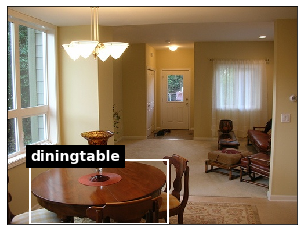

In [14]:
image_id = 235
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
draw_bbox(ax, annotation_dict_large[image_id][1])
add_text(ax, annotation_dict_large[image_id][1], image_id_to_category[annotation_dict_large[image_id][0]])

In [15]:
df = pd.DataFrame(
{
    'image_path': [image_id_to_filename[id] for id in annotation_dict_large],
    'category': [image_id_to_category[annotation_dict_large[id][0]] for id in annotation_dict_large],
    'bbox': [','.join(list(map(str, hw_to_coord(
        annotation_dict_large[id][1], id, normalize=True)))) for id in annotation_dict_large]
})


df.head()

bbox   category  \
0  0.634,0.48348348348348347,0.934,0.858858858858...  tvmonitor   
1    0.9,0.5552238805970149,0.994,0.6776119402985075        car   
2                              0.726,0.224,0.998,1.0     person   
3                  0.38,0.7466666666666667,0.848,1.0      chair   
4               0.074,0.49866666666666665,0.608,0.96       sofa   

                                     image_path  
0  data/VOCdevkit/VOC2007/JPEGImages/004100.jpg  
1  data/VOCdevkit/VOC2007/JPEGImages/008197.jpg  
2  data/VOCdevkit/VOC2007/JPEGImages/008199.jpg  
3  data/VOCdevkit/VOC2007/JPEGImages/004106.jpg  
4  data/VOCdevkit/VOC2007/JPEGImages/008203.jpg

In [16]:
categories = np.unique(df.category)
print (categories)

cat_to_int = dict()
int_to_cat = dict()

for idx, cat in enumerate(categories):
    cat_to_int[cat] = idx
    int_to_cat[idx] = cat
    
df.category = df.category.map(cat_to_int)

['aeroplane' 'bicycle' 'bird' 'boat' 'bottle' 'bus' 'car' 'cat' 'chair'
 'cow' 'diningtable' 'dog' 'horse' 'motorbike' 'person' 'pottedplant'
 'sheep' 'sofa' 'train' 'tvmonitor']


In [17]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from glob import glob
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [18]:
class MyCustomDataset(Dataset):
    def __init__(self, df, phase):
        self.df = df
        self.transforms = data_transforms[phase]              
        
    def __getitem__(self, index):
        image = read_image(str(self.df.iloc[index]['image_path']))
        image = self.transforms(image)        
        label = catutil.encode(self.df.iloc[index]['category'])
        bbox = self.df.iloc[index]['bbox']
        bbox = torch.tensor(list(map(float, bbox.split(','))))
        return image, label, bbox

    def __len__(self):
        return self.df.shape[0]


df = df.sample(frac=1)

n_train = int(df.shape[0]*80/100)
n_val = df.shape[0] - n_train
df_train = df.head(n_train)
df_val = df.tail(n_val)

catutil = CategoryUtil(df.category)

dataset = MyCustomDataset(df_train, 'train')
train_data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset = MyCustomDataset(df_val, 'val')
val_data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

dataloaders_dict = {
    'train': train_data_loader,
    'val': val_data_loader
}

In [19]:
df.head()

bbox  category  \
1244                              0.152,0.78,0.784,0.97         5   
2337               0.008,0.006006006006006006,0.862,1.0        14   
342   0.028,0.30666666666666664,0.532,0.642666666666...         3   
2012                  0.26,0.2906666666666667,0.716,1.0         2   
977                 0.218,0.16,0.922,0.7173333333333334         7   

                                        image_path  
1244  data/VOCdevkit/VOC2007/JPEGImages/005961.jpg  
2337  data/VOCdevkit/VOC2007/JPEGImages/003817.jpg  
342   data/VOCdevkit/VOC2007/JPEGImages/008725.jpg  
2012  data/VOCdevkit/VOC2007/JPEGImages/008051.jpg  
977   data/VOCdevkit/VOC2007/JPEGImages/001486.jpg

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, bboxes in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device).to(dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
#                         print (outputs.size())
                        loss1 = criterion1(outputs[:, :4], bboxes)
#                         print ('loss1', loss1)
#                         print (outputs[:, 4:20].size(), labels.size())
#                         print (outputs[:, 4:20])
                        loss2 = criterion2(outputs[:, 4:], labels)
#                         print (loss1.item(), loss2.item())
#                     continue

#                     _, preds = torch.max(outputs, 1)
            
                    loss = (loss1 * 10 + loss2)/2.0
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [22]:
model_ft = tv.models.resnet101(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extracting=True)
num_ftrs = model_ft.fc.in_features

num_classes = 4+20
model_ft.fc = nn.Linear(num_ftrs, num_classes)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
model_ft = model_ft.to(device)

In [25]:
params_to_update = []
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

In [26]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [27]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
num_epochs=64

In [28]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion1, criterion2, optimizer_ft, num_epochs=num_epochs, is_inception=False)
torch.save(model_ft.state_dict(),'./model_ft.pth')

Epoch 0/63
----------
train Loss: 1.6824
val Loss: 1.2296

Epoch 1/63
----------
train Loss: 1.1239
val Loss: 0.9324

Epoch 2/63
----------
train Loss: 0.9285
val Loss: 0.7840

Epoch 3/63
----------
train Loss: 0.8475
val Loss: 0.7827

Epoch 4/63
----------
train Loss: 0.7398
val Loss: 0.6517

Epoch 5/63
----------
train Loss: 0.7099
val Loss: 0.7269

Epoch 6/63
----------
train Loss: 0.7114
val Loss: 0.5732

Epoch 7/63
----------
train Loss: 0.6686
val Loss: 0.6258

Epoch 8/63
----------
train Loss: 0.6180
val Loss: 0.5707

Epoch 9/63
----------
train Loss: 0.6176
val Loss: 0.5826

Epoch 10/63
----------
train Loss: 0.5941
val Loss: 0.5070

Epoch 11/63
----------
train Loss: 0.5866
val Loss: 0.5428

Epoch 12/63
----------
train Loss: 0.5712
val Loss: 0.5066

Epoch 13/63
----------
train Loss: 0.5796
val Loss: 0.4992

Epoch 14/63
----------
train Loss: 0.5476
val Loss: 0.6009

Epoch 15/63
----------
train Loss: 0.5543
val Loss: 0.5139

Epoch 16/63
----------
train Loss: 0.5292
val Loss

In [30]:
#==============

def denormalize(image, _mean=None, _std=None):
    if _mean is None and _std is None:
        _mean = [0.485, 0.456, 0.406]
        _std = [0.229, 0.224, 0.225]
    for i in range(3):
        image[:, i, :, :] = image[:, i, :, :] * _std[i] + _mean[i]
    return image

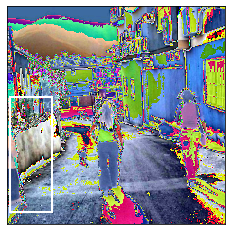

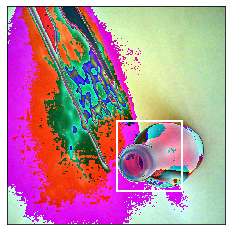

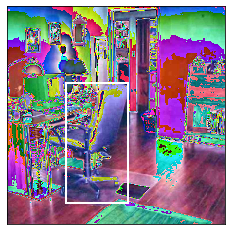

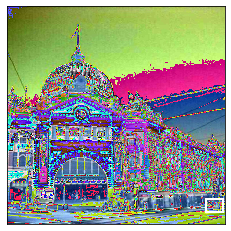

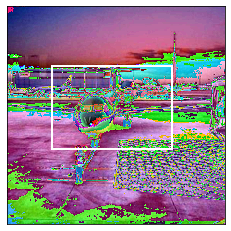

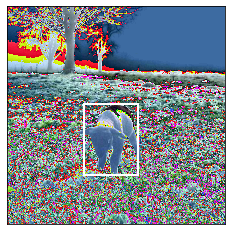

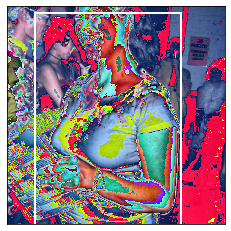

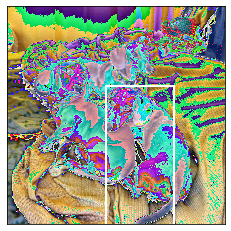

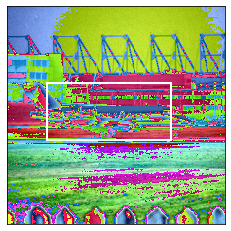

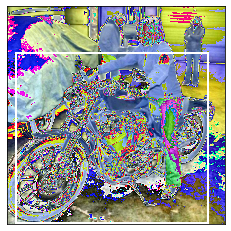

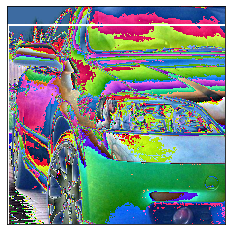

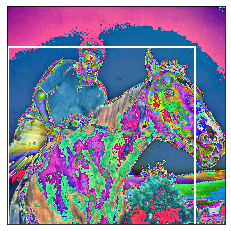

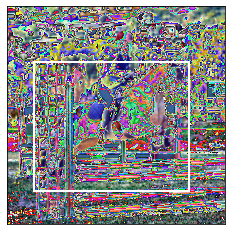

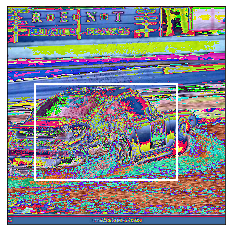

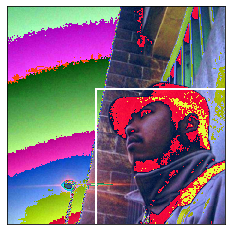

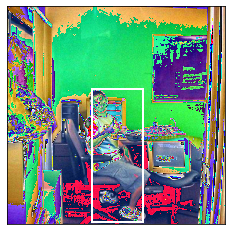

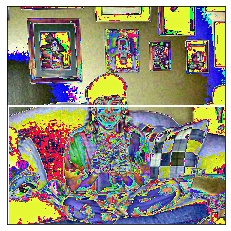

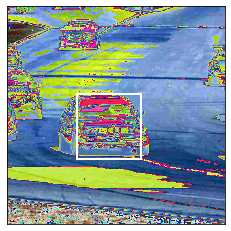

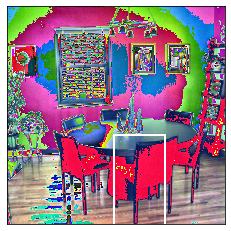

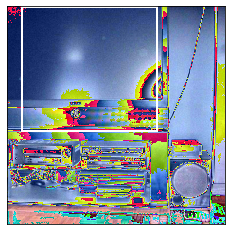

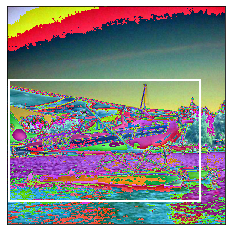

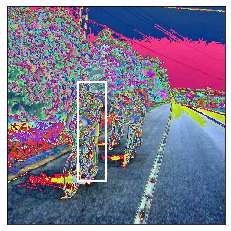

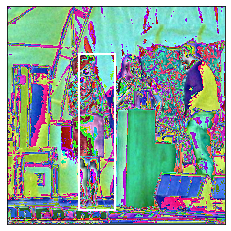

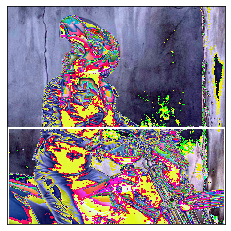

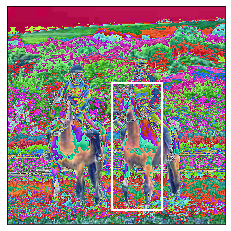

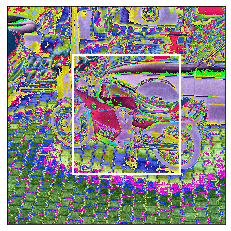

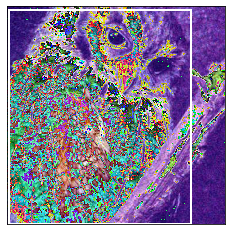

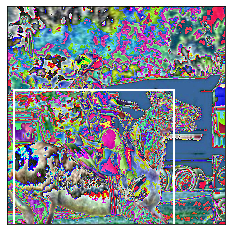

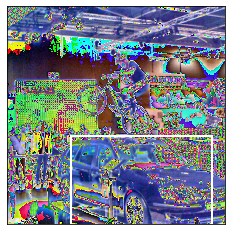

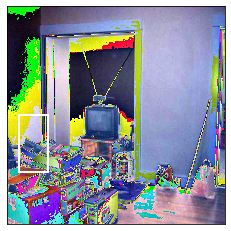

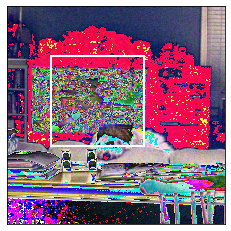

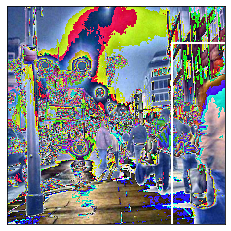

In [38]:
to_pil = transforms.ToPILImage()
for inputs, labels, bboxes in val_data_loader:
    inputs, bboxes = inputs.cuda(), bboxes.cuda()
#     predictions = model_ft(inputs)
#     inputs = denormalize(inputs)
#     predictions = predictions.cpu().data.numpy().astype(int)
    for inp, bbox in zip(inputs, bboxes):
        ax = draw_image(to_pil(inp.cpu()))
        bbox[0], bbox[2] = bbox[0] * 224.0, bbox[2] *224.0
        bbox[1], bbox[3] = bbox[1] * 224.0, bbox[3] * 224.0
        bbox = coord_to_hw(bbox)
        draw_bbox(ax, bbox)
#         print (bbox)
#         lbl = catutil.decode(lbl.item())
#         add_text(ax, [5, 5], lbl)
    break

/home/guest/maruf/venv3/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


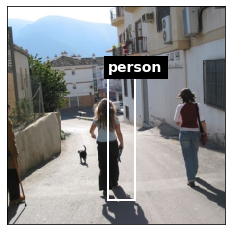

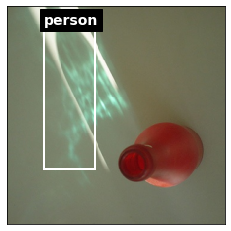

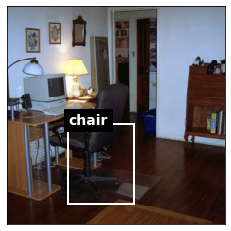

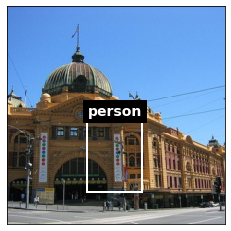

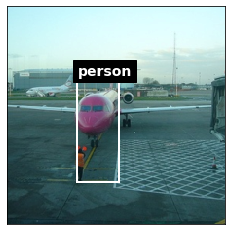

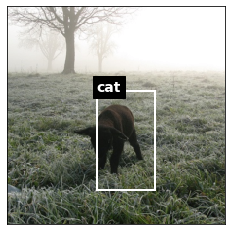

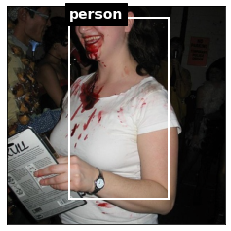

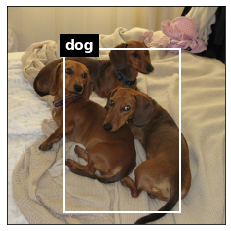

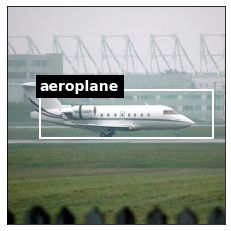

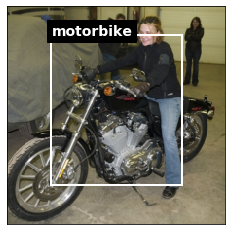

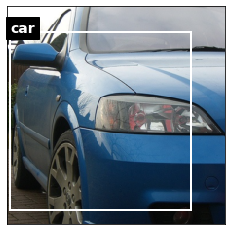

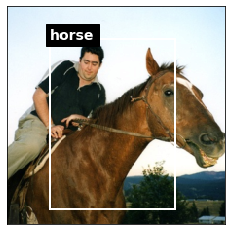

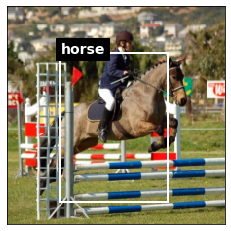

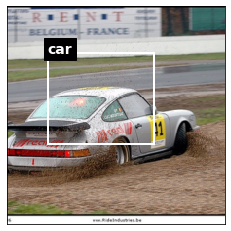

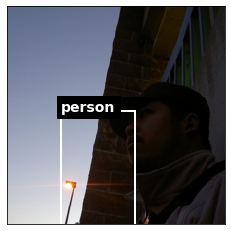

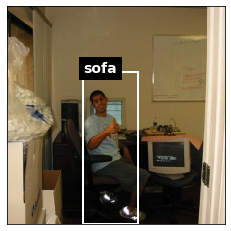

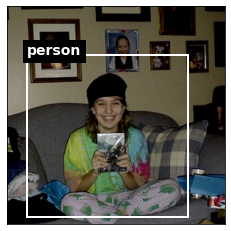

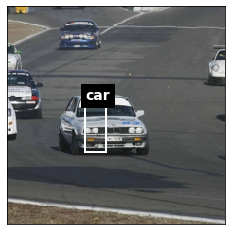

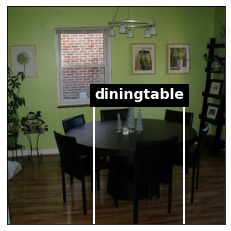

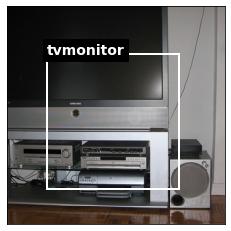

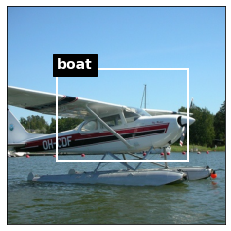

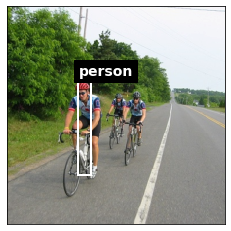

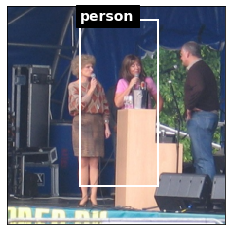

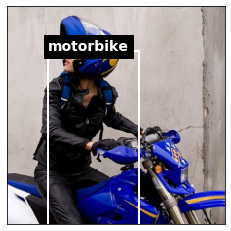

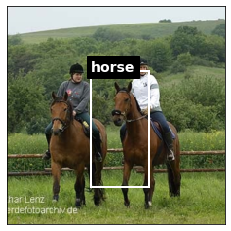

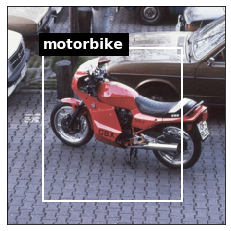

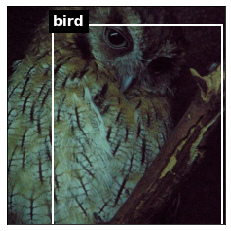

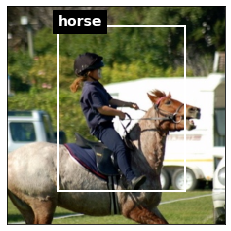

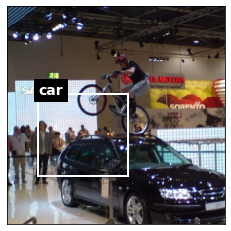

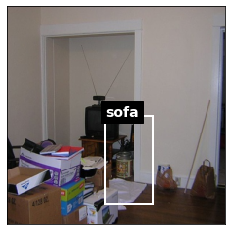

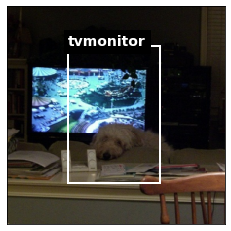

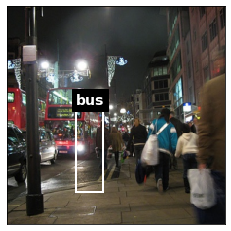

In [58]:
to_pil = transforms.ToPILImage()

for inputs, labels, bboxes in val_data_loader:
    inputs = inputs.cuda()
    predictions = model_ft(inputs)
    p_bboxes = predictions[:, :4]
    p_labels = predictions[:, 4:]
    inputs = denormalize(inputs)
    for inp, bbox, label in zip(inputs, p_bboxes, p_labels):
        ax = draw_image(to_pil(inp.cpu()))
        bbox[0], bbox[2] = bbox[0] * 224.0, bbox[2] *224.0
        bbox[1], bbox[3] = bbox[1] * 224.0, bbox[3] * 224.0
        bbox = coord_to_hw(bbox)
        draw_bbox(ax, bbox)
        label = torch.argmax(label).item()
        add_text(ax, bbox, int_to_cat[label])
    break